# Coronavirus/COVID-19 Timseries Forecasting

- ~~[GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)~~
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

> **~~NOTE: DATA ACQUISITION IS BEING RE-WORKED IN "Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipnynb"~~** -08/12/21

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

- See `data_acquisition.py`> `FULL_WORKFLOW()` and `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for details (for now)


# OBTAIN

## Imports

In [1]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *

import os,glob,sys,joblib,zipfile,json
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
### FORECAST SPECIFIC FUNCTIONS
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

In [3]:
import statsmodels
print(f"Statsmodels version: {statsmodels.__version__}")

import pmdarima
print(f"pmdarima version: {pmdarima.__version__}")

Statsmodels version: 0.12.2
pmdarima version: 1.8.2


In [4]:
## Custom Functions and Classes
%load_ext autoreload
%autoreload 2
import project_functions as fn

## Data

In [5]:
## Using new savedd FILE_DIRECTORIES
import os,json,glob

with open("FILE_DIRECTORY.json") as f:
    FPATHS = json.load(f)
FPATHS

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars',
  'fpath_final_states'],
 'fpath_final_states': './data/FINAL_STATES.joblib'}

In [6]:
for path_name,fpath in FPATHS.items():
    try:
        
        found_files =  sorted(os.listdir(fpath))
        print(f"\n[i] Files stored in {path_name}:")
        [print("\t",i,x) for i,x in enumerate(found_files)]
    except:
        pass



[i] Files stored in fpath_raw:
	 0 .ipynb_checkpoints
	 1 CONVENIENT_us_metadata.csv
	 2 RAW_us_confirmed_cases.csv
	 3 RAW_us_deaths.csv
	 4 covid19-data-from-john-hopkins-university.zip
	 5 hospital_data.csv

[i] Files stored in fpath_clean:
	 0 COLUMNS.joblib
	 1 FINAL_STATES.csv.gz
	 2 FINAL_STATES.joblib
	 3 FINAL_STATES.pickle
	 4 STATE_DICT.joblib
	 5 combined_us_states_full_data.csv
	 6 state_data
	 7 us_states_cases_deaths.csv
	 8 us_states_daily_cases_deaths.csv

[i] Files stored in fpath_reference:
	 0 COLUMNS.joblib
	 1 population-by-country-2020.zip
	 2 state_codes_to_names_map.joblib
	 3 state_names_to_codes_map.joblib
	 4 united_states_abbreviations.csv
	 5 us_metadata_counties.csv
	 6 us_metadata_states.csv

[i] Files stored in fpath_state_data:


### Project Control Booleans

In [7]:
RUN_FULL_WORKFLOW=True

In [8]:
# ## making mapper dict to rename new columns
# new_to_match_old_map = {
#     'Deaths':'death',
#     'Cases':'positive',
#     'total_adult_patients_hospitalized_confirmed_covid':'hospitalizedCurrently',
# 'adult_icu_bed_covid_utilization_numerator':'inIcuCurrently'}
# ## making mapper dict to rename new columns
# new_to_final_names = {
#     'Deaths':'Deaths',
#     'Cases':'Cases',
#     'total_adult_patients_hospitalized_confirmed_covid':'Hospitalized Currently',
# 'adult_icu_bed_covid_utilization_numerator':'ICU-Covid Currently'}
# list(new_to_final_names.keys())

In [9]:
FPATHS

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars',
  'fpath_final_states'],
 'fpath_final_states': './data/FINAL_STATES.joblib'}

In [10]:
os.listdir(FPATHS['fpath_clean'])

['us_states_daily_cases_deaths.csv',
 'state_data',
 'combined_us_states_full_data.csv',
 'us_states_cases_deaths.csv',
 'STATE_DICT.joblib',
 'FINAL_STATES.joblib',
 'FINAL_STATES.csv.gz',
 'COLUMNS.joblib',
 'FINAL_STATES.pickle']

In [11]:
## temporary override
RUN_FULL_WORKFLOW=False

In [14]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES = fn.data.FULL_WORKFLOW(merge_hospital_data=True)
    ## renaming since merge_hofspital_data=True
#     DF = df_states.copy()
#     print(STATES.keys())    
    
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_pickle(FPATHS['fpath_final_df_pickle'])
    
#     with open(FPATHS['fpath_final_states']) as f:
    STATES = joblib.load(FPATHS['fpath_final_states'])
#     df_states = pd.read_csv(os.path.join(fpath_clean,
#                                          'combined_us_states_full_data.csv'))
#     STATES = joblib.load(os.path.join(fpath_clean,'STATE_DICT.joblib'))

display(df_states.head())
print(STATES.keys())

[i] Using previously downloaded data...


Deaths  Cases  Hospitalized Currently  ICU-Covid Currently  Deaths-New  Cases-New
   Date                                                                                         
AK 2020-03-23       0     39                     0.0                  0.0         0.0        0.0
   2020-03-24       0     43                     0.0                  0.0         0.0        4.0
   2020-03-25       1     50                     0.0                  0.0         1.0        7.0
   2020-03-26       1     64                     0.0                  0.0         0.0       14.0
   2020-03-27       1     75                     0.0                  0.0         0.0       11.0

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])


# [To Be Updated] COPIED legacy book 2 on  09/06/21

# EDA - Comparing States

## FL

In [15]:
FL = STATES['FL'].copy()
FL

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-03-12,2,30,0.0,0.0,0.0,0.0
2020-03-13,2,50,0.0,0.0,0.0,20.0
2020-03-14,2,76,0.0,0.0,0.0,26.0
2020-03-15,3,100,0.0,0.0,1.0,24.0
2020-03-16,3,101,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2021-08-31,43979,3223249,14995.0,3375.0,0.0,0.0
2021-09-02,43979,3223249,14267.0,3281.0,0.0,0.0
2021-09-03,46324,3352451,13666.0,3230.0,2345.0,129202.0


In [16]:
## first non-null hospital timestamps
first_ts = FL[FL['Hospitalized Currently'].notna()].index[0]
first_ts

Timestamp('2020-03-12 00:00:00')

### Calc Delta Cases/Deaths

In [17]:
FL.columns

Index(['Deaths', 'Cases', 'Hospitalized Currently', 'ICU-Covid Currently',
       'Deaths-New', 'Cases-New'],
      dtype='object')

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

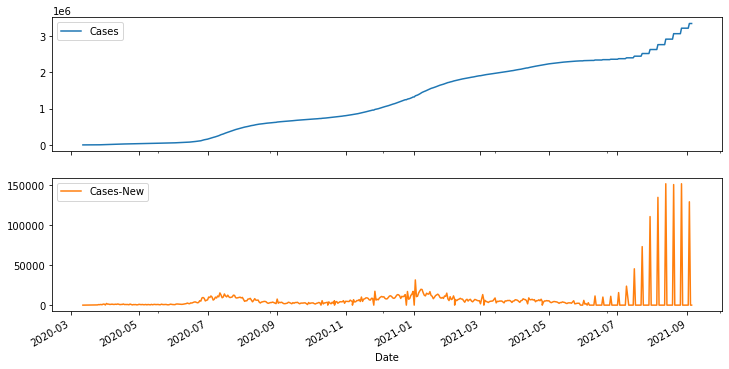

In [18]:
## Plot deaths/cases
cumulative_cols = [c for c in FL.columns for name in ['Daths','Cases']if name in c]
FL[cumulative_cols].plot(subplots=True)

In [19]:
import plotly
plotly.__version__

'5.3.1'

<AxesSubplot:>

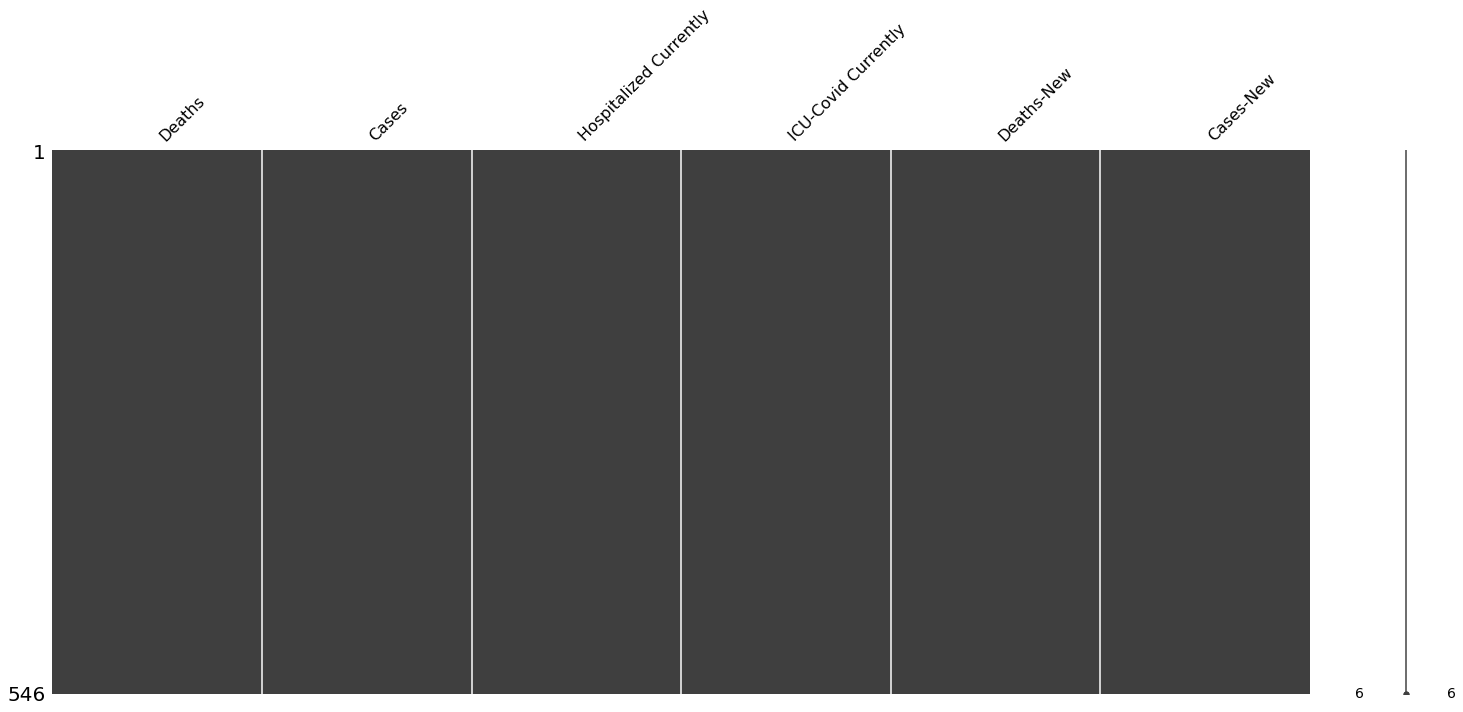

In [20]:
import missingno
missingno.matrix(FL)

In [21]:
# px.imshow(FL.isna(),template='plotly_dark',color_continuous_scale="Reds")

In [22]:
plot_cols = FL.drop(columns=cumulative_cols).columns
plot_cols

Index(['Deaths', 'Hospitalized Currently', 'ICU-Covid Currently',
       'Deaths-New'],
      dtype='object')

In [23]:
pfig = px.line(FL,y=plot_cols,width=1000,title="FL Data")
pfig.add_vline(first_ts,line_width=3,line_dash="dash",name='Start')
pfig.show()

In [27]:
# raise Exception('end of 09/01/21, though below code is still good.')

# Time Series Modeling

In [25]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

## MD

In [28]:
state = "MD"
df_state = STATES[state].loc['08-2020':].copy()
# df_state = df_state.interpolate('time')
df_state['Deaths-New'] = df_state['Deaths'].diff()
df_state['Cases-New'] = df_state['Cases'].diff()
df_state = df_state.resample('D').sum()

print(df_state.isna().sum())
df_state

Deaths                    0
Cases                     0
Hospitalized Currently    0
ICU-Covid Currently       0
Deaths-New                0
Cases-New                 0
dtype: int64


,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-08-01,3506,89365,629.0,171.0,0.0,0.0
2020-08-02,3515,90274,606.0,180.0,9.0,909.0
2020-08-03,3523,91144,574.0,176.0,8.0,870.0
2020-08-04,3530,91854,576.0,191.0,7.0,710.0
2020-08-05,3536,92426,571.0,186.0,6.0,572.0
...,...,...,...,...,...,...
2021-09-01,10024,498376,759.0,202.0,10.0,1374.0
2021-09-02,10040,499648,799.0,212.0,16.0,1272.0
2021-09-03,10051,501035,813.0,222.0,11.0,1387.0


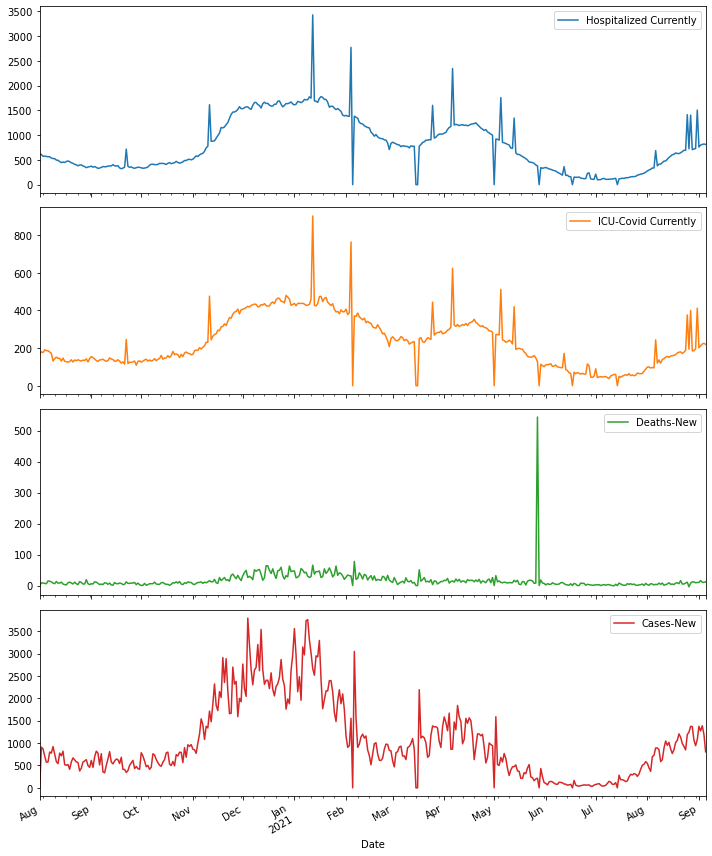

In [29]:
model_cols = ['Hospitalized Currently','ICU-Covid Currently',
              'Deaths-New','Cases-New'
             ]

## visualize
ax = df_state[model_cols].plot(subplots=True, figsize=(10,12))
plt.tight_layout();

#### Data Quality Issues
- There are strong spikes +/- that are not likely to be real values.

### MD - Cases-New

Text(0, 0.5, 'Cases-New')

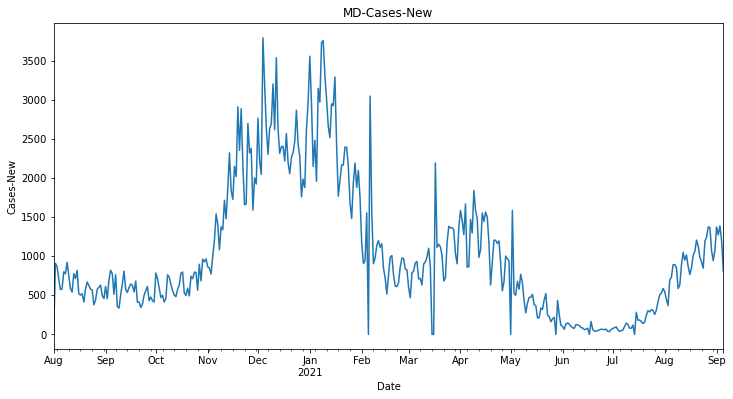

In [30]:
col = 'Cases-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 08-07-2021


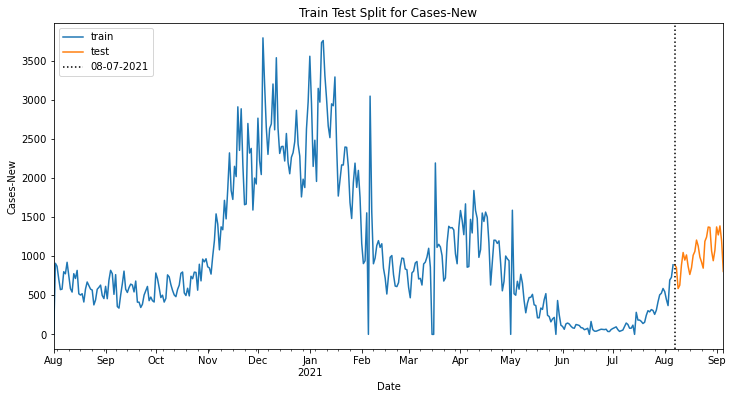

In [31]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

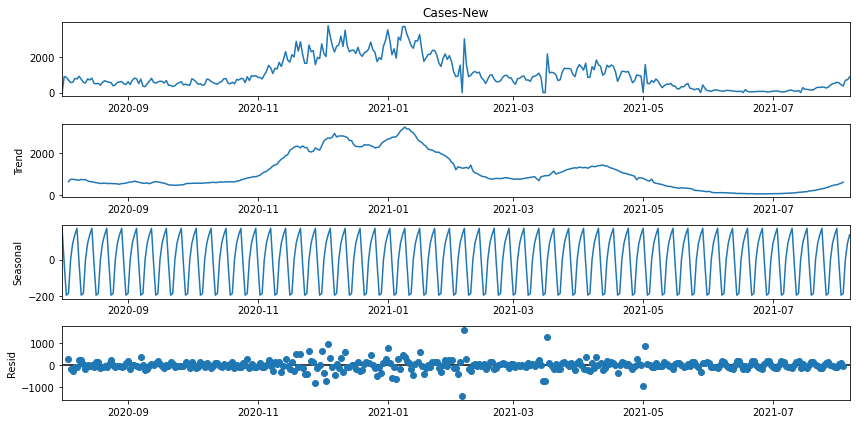

In [32]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

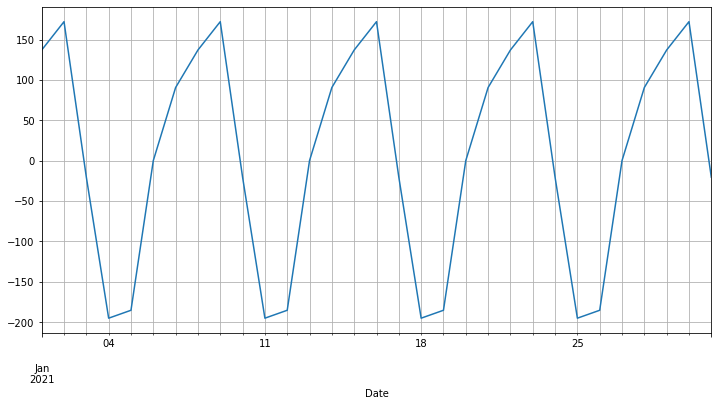

In [33]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.781987,16,347,0.060893,False,False


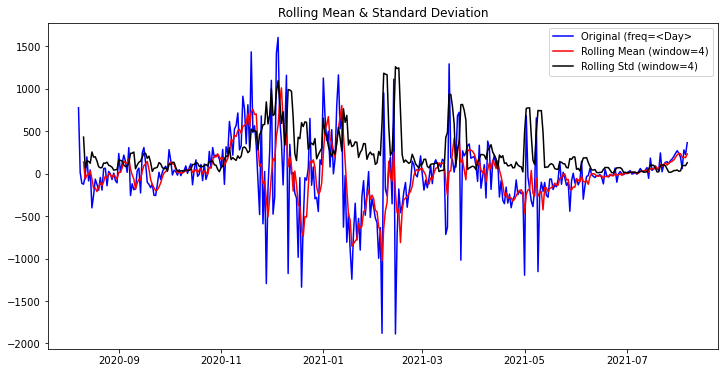

In [34]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

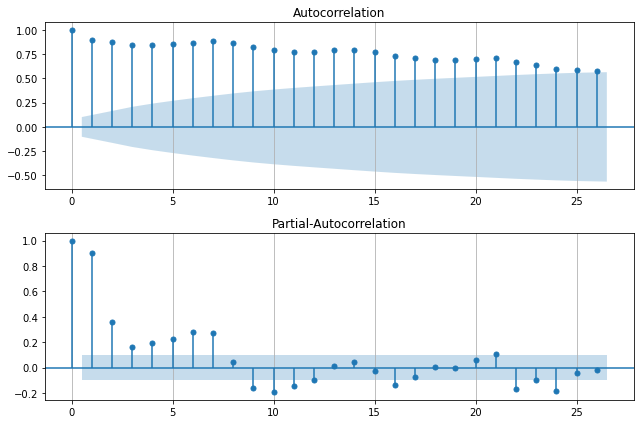

In [35]:
fn.modeling.plot_acf_pacf(train,);

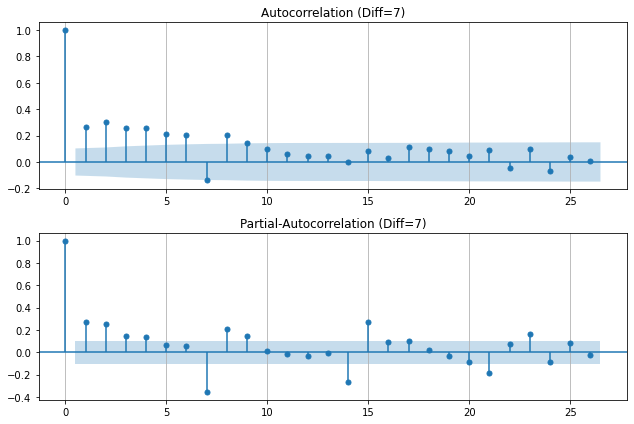

In [36]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [37]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5431.532, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5367.990, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5393.775, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5429.533, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=5405.818, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5343.886, Time=0.51 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=5341.252, Time=1.42 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=5341.259, Time=0.72 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=5342.156, Time=1.52 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=5342.308, Time=1.83 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=5430.095, Time=0.99 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=5262.783, Time=2.79 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=5262.271, Time=1.47 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=5260.272, Time=1.39 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  371
Model:             SARIMAX(5, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -2608.576
Date:                             Mon, 06 Sep 2021   AIC                           5231.152
Time:                                     17:46:44   BIC                           5258.432
Sample:                                          0   HQIC                          5241.995
                                             - 371                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2858      0.035      8.264      0.000       0.218       0.354
ar.L2          0.2780      0.044      6.250      0.000       0.191       0.365
ar.L3          0.1367      0.045      3.017      0.003       0.048       0.226
ar.L4          0.1286      0.066      1.938      0.053      -0.001       0.259
ar.L5          0.1127      0.057      1.975      0.048       0.001       0.224
ma.S.L7       -0.8075      0.033    -24.412      0.000      -0.872      -0.743
sigma2      9.671e+04   3807.408     25.400      0.000    8.92e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1290.18
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Cases-New   No. Observations:                  371
Model:             SARIMAX(5, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -2550.641
Date:                             Mon, 06 Sep 2021   AIC                           5115.282
Time:                                     17:46:45   BIC                           5142.407
Sample:                                 08-01-2020   HQIC                          5126.072
                                      - 08-06-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2825      0.034      8.222      0.000       0.215       0.350
ar.L2          0.2808      0.044      6.342      0.000       0.194       0.368
ar.L3          0.1434      0.045      3.185      0.001       0.055       0.232
ar.L4          0.1308      0.066      1.988      0.047       0.002       0.260
ar.L5          0.1070      0.057      1.884      0.060      -0.004       0.218
ma.S.L7       -0.8114      0.033    -24.300      0.000      -0.877      -0.746
sigma2      9.634e+04   3780.386     25.484      0.000    8.89e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1303.82
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

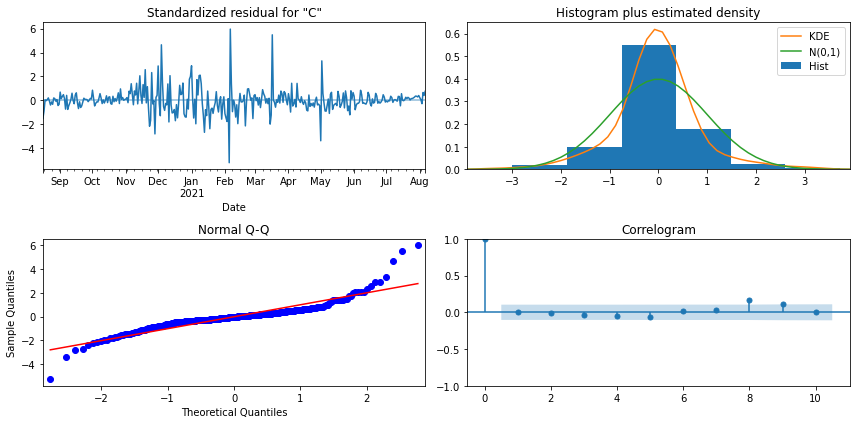

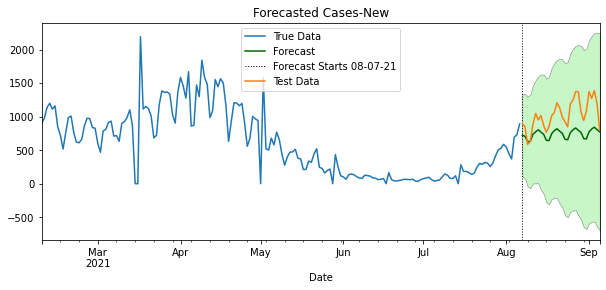

In [38]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Cases-New   No. Observations:                  401
Model:             SARIMAX(5, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -2752.522
Date:                             Mon, 06 Sep 2021   AIC                           5519.045
Time:                                     17:46:47   BIC                           5546.736
Sample:                                 08-01-2020   HQIC                          5530.026
                                      - 09-05-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2879      0.032      8.944      0.000       0.225       0.351
ar.L2          0.2792      0.042      6.727      0.000       0.198       0.361
ar.L3          0.1413      0.042      3.352      0.001       0.059       0.224
ar.L4          0.1287      0.062      2.083      0.037       0.008       0.250
ar.L5          0.1096      0.053      2.057      0.040       0.005       0.214
ma.S.L7       -0.8106      0.031    -25.895      0.000      -0.872      -0.749
sigma2      9.013e+04   3300.246     27.310      0.000    8.37e+04    9.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1639.01
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

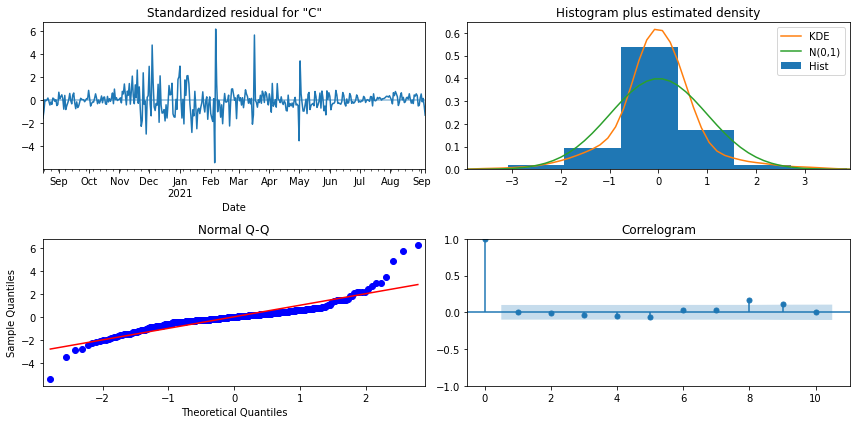

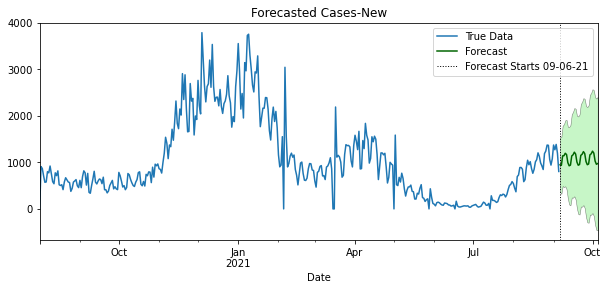

In [39]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Deaths-New

Text(0, 0.5, 'Deaths-New')

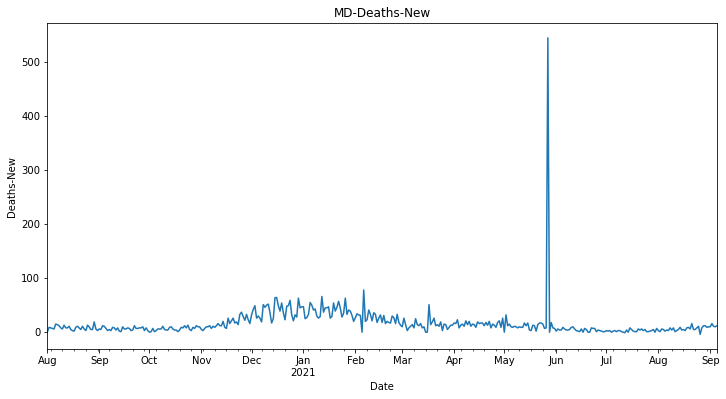

In [40]:
col = 'Deaths-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

## 🚨 BOOKMARK: Data Quality Issue - Deaths

- To Do: Remove outliers.
    - Try using .diff() and a high threshold for deterining outliers

In [102]:
## saving deltas 
threshold=1000
deltas  = ts.diff()
outliers= deltas[deltas>threshold]
outliers.sum()

5628.0

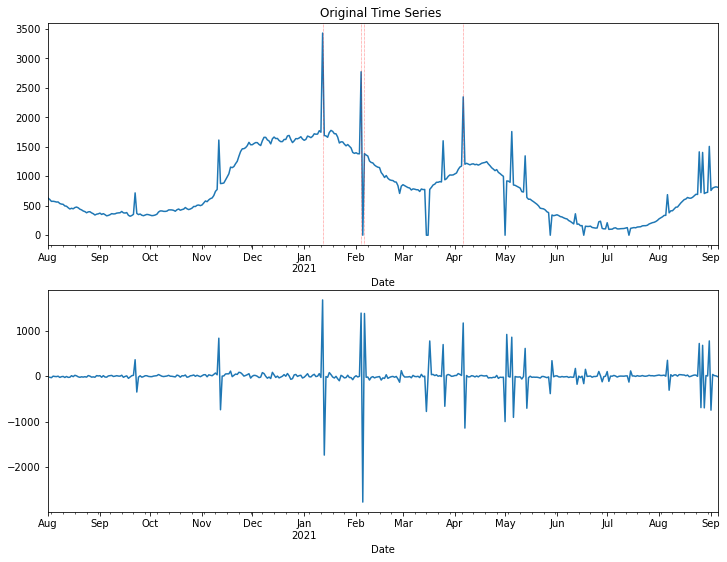

In [103]:
## Plotting High Deltas on original time seires

## saving deltas 
fig, axes = plt.subplots(nrows=2,figsize=(12,9))


ax = ts.plot(ax = axes[0])
[ax.axvline(x_val,lw=0.5,ls = ':',color='red') for x_val in outliers.index]
ax.set(title='Original Time Series ')


ax = deltas.plot(ax=axes[1])

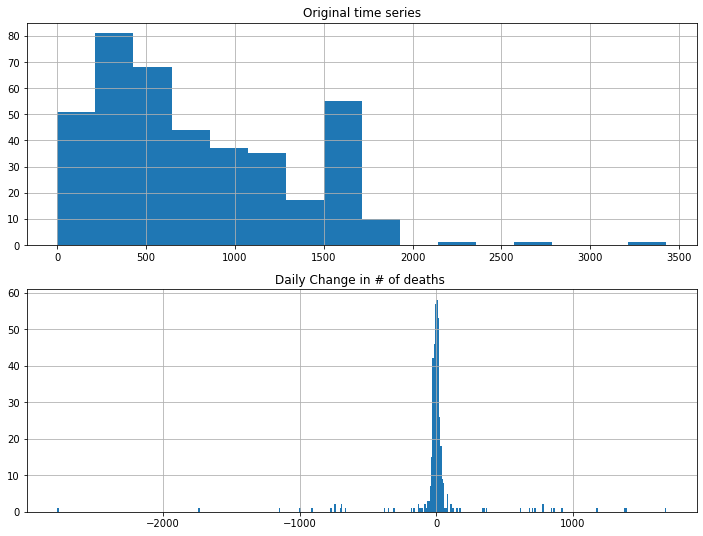

In [104]:
## saving deltas 
fig, axes = plt.subplots(nrows=2,figsize=(12,9))
ax0 = ts.hist(bins='auto',ax=axes[0])
ax0.set(title='Original time series')

## saving deltas 
ax1 = deltas.hist(bins='auto',ax=axes[1])
ax1.set(title='Daily Change in # of deaths ');

In [105]:
raise Exception('Deal with the data quality issue above')

#### Train Test Split

Using a cutoff index of -30, which = 08-07-2021


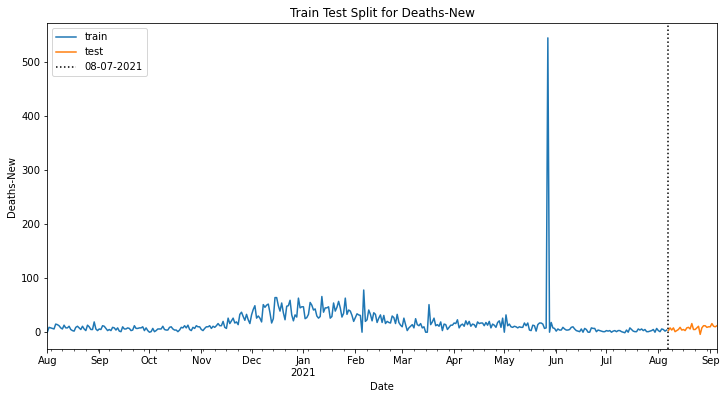

In [41]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

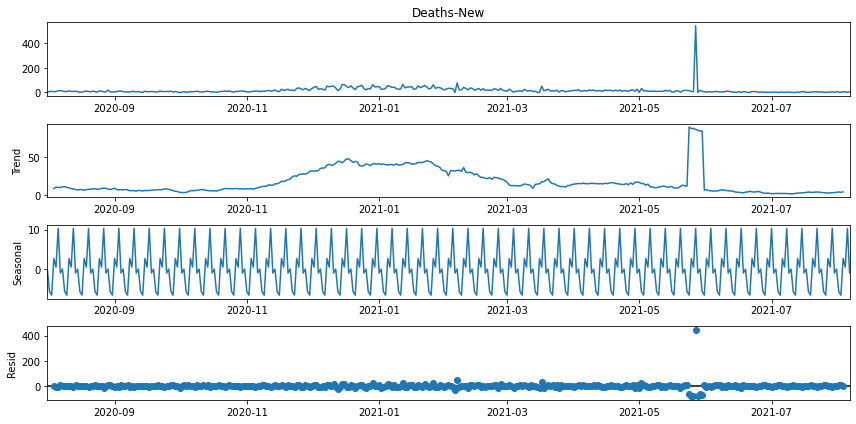

In [42]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

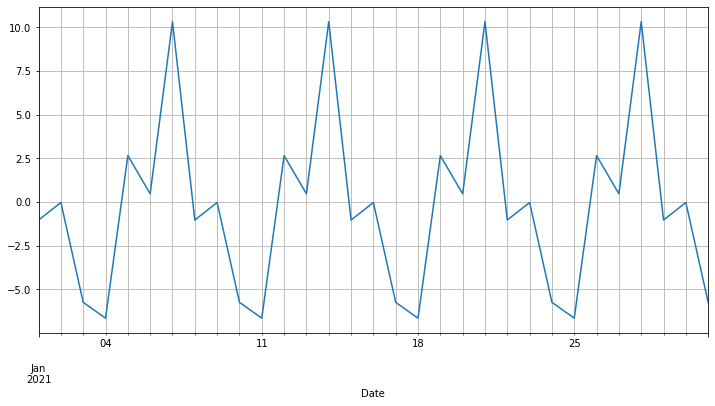

In [43]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-7.80544,13,350,7.302842e-12,True,True


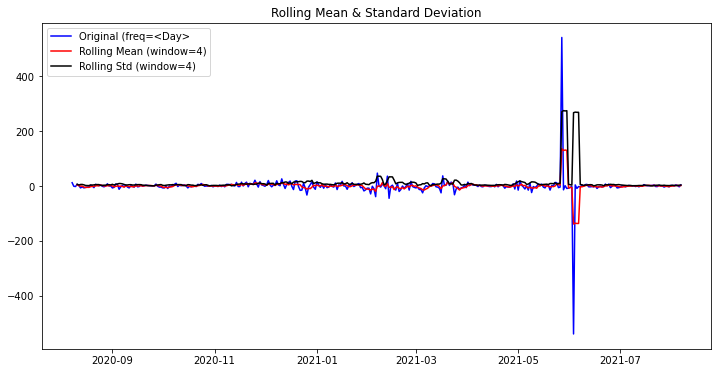

In [44]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

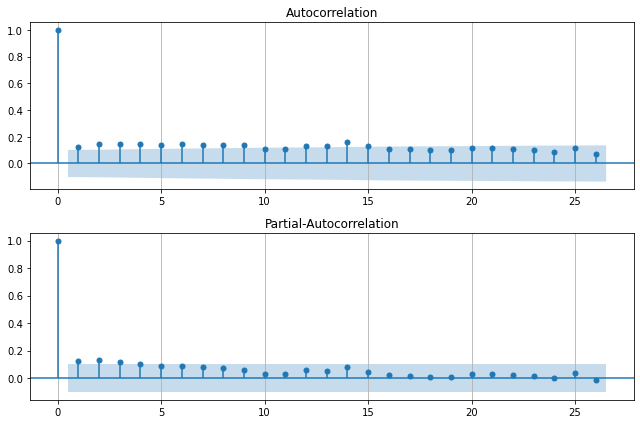

In [45]:
fn.modeling.plot_acf_pacf(train,);

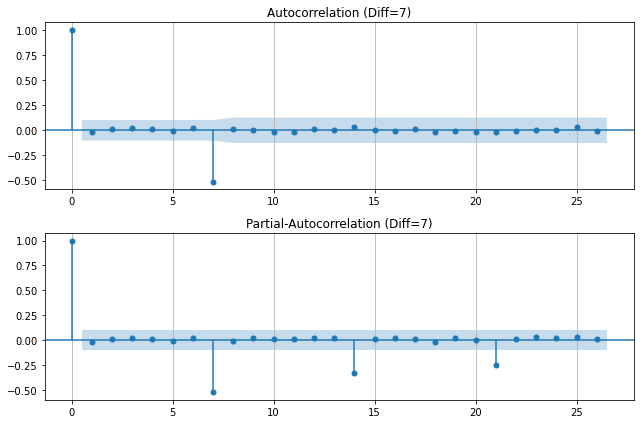

In [46]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [47]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3743.006, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3638.524, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3556.434, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3741.008, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=3744.858, Time=0.11 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=3558.360, Time=1.46 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=3638.527, Time=0.22 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=3560.433, Time=2.16 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=3555.656, Time=0.18 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=3557.613, Time=0.57 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=3557.620, Time=0.67 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=3636.587, Time=0.33 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=3559.600, Time=1.87 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  371
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood               -1774.839
Date:                   Mon, 06 Sep 2021   AIC                           3553.677
Time:                           17:47:05   BIC                           3561.471
Sample:                                0   HQIC                          3556.775
                                   - 371                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8430      0.018    -47.077      0.000      -0.878      -0.808
sigma2       982.5731      7.545    130.223      0.000     967.784     997.362
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):            755189.20
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              40.26   Skew:                            13.13
Prob(H) (two-sided):                  0.00   Kurtosis:                       224.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                Deaths-New   No. Observations:                  371
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood               -1737.889
Date:                   Mon, 06 Sep 2021   AIC                           3479.778
Time:                           17:47:05   BIC                           3487.528
Sample:                       08-01-2020   HQIC                          3482.861
                            - 08-06-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8481      0.019    -45.443      0.000      -0.885      -0.812
sigma2      1003.4759      7.947    126.277      0.000     987.901    1019.051
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):            707324.44
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              25.38   Skew:                            13.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       219.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

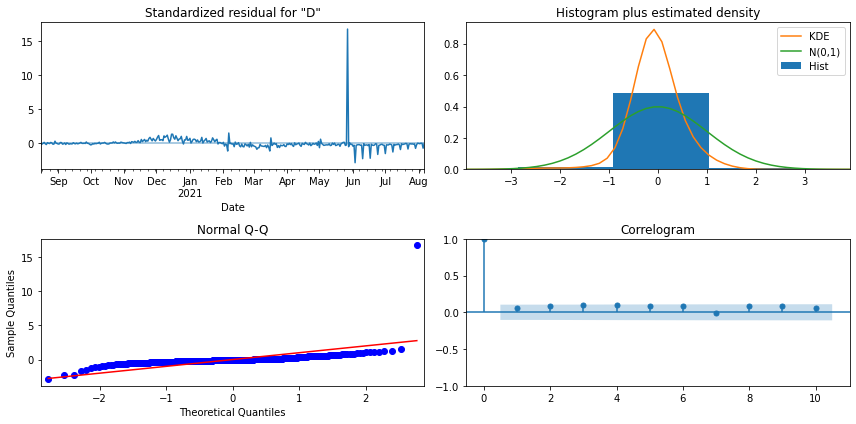

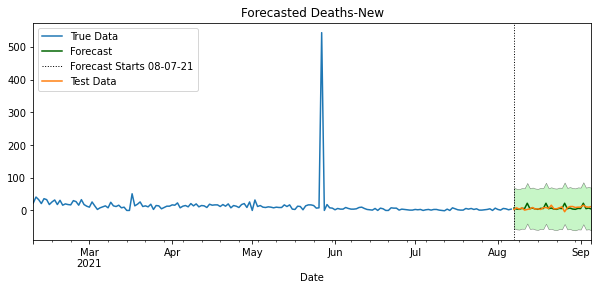

In [48]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                Deaths-New   No. Observations:                  401
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood               -1869.218
Date:                   Mon, 06 Sep 2021   AIC                           3742.437
Time:                           17:47:07   BIC                           3750.349
Sample:                       08-01-2020   HQIC                          3745.574
                            - 09-05-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8437      0.017    -49.741      0.000      -0.877      -0.810
sigma2       929.2421      6.755    137.557      0.000     916.002     942.482
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):            890409.73
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              16.64   Skew:                            13.46
Prob(H) (two-sided):                  0.00   Kurtosis:                       236.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

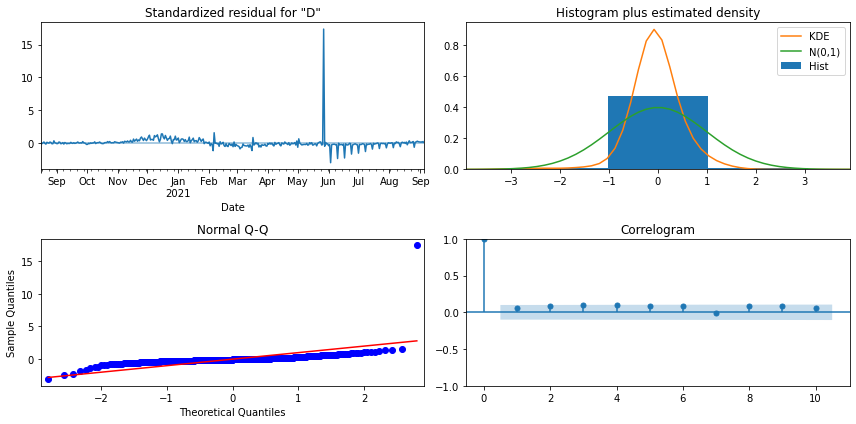

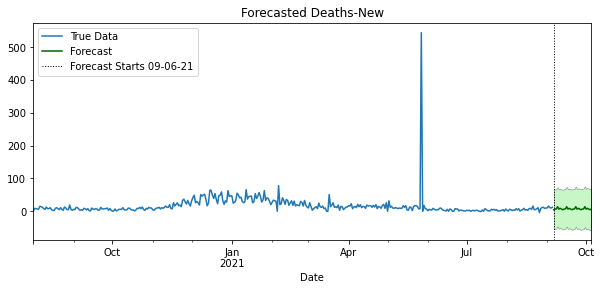

In [49]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Hospitalized Currently

In [50]:
# df_state['Hospitalized Currently']

Text(0, 0.5, 'Hospitalized Currently')

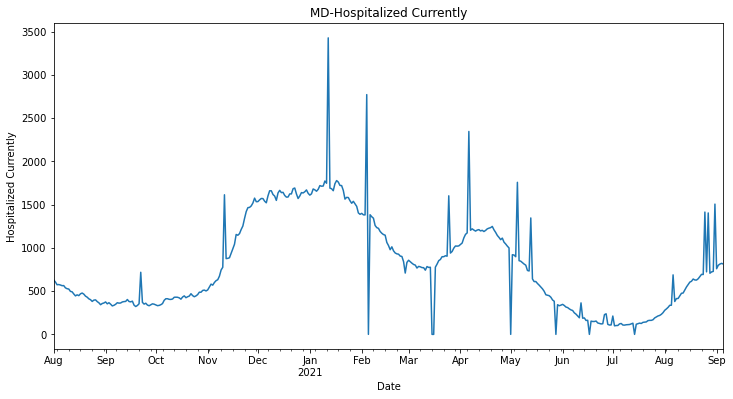

In [51]:
col = 'Hospitalized Currently'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 08-07-2021


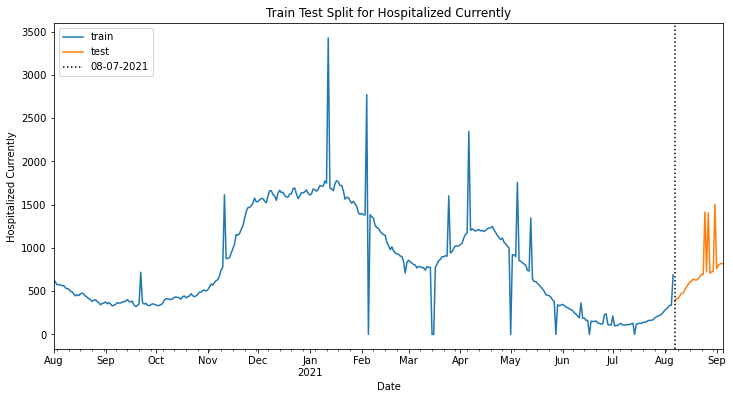

In [52]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

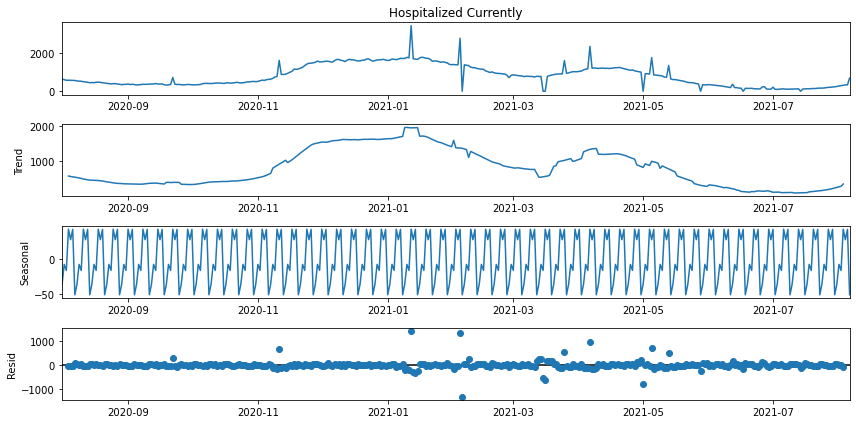

In [53]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

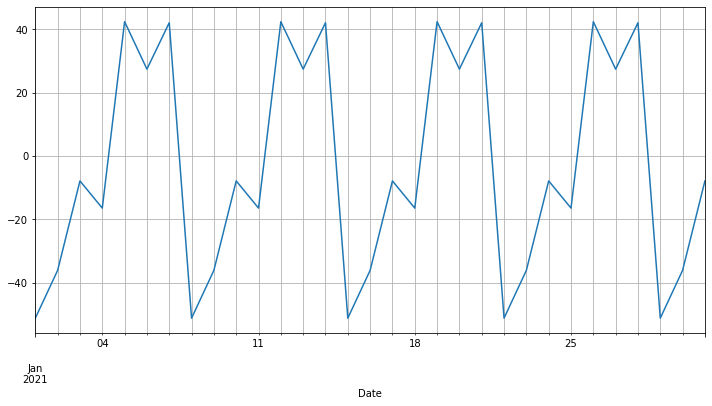

In [54]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.407928,16,347,0.139511,False,False


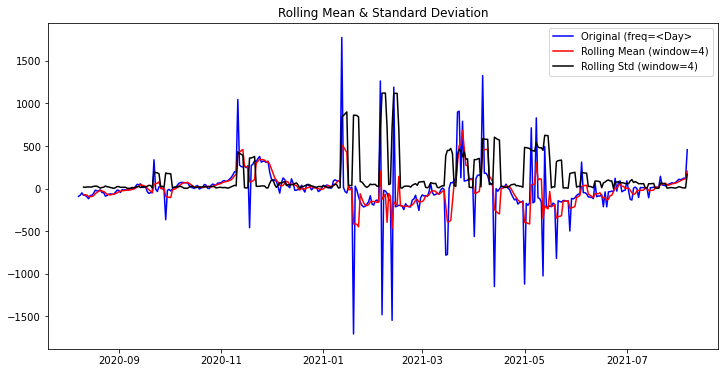

In [55]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

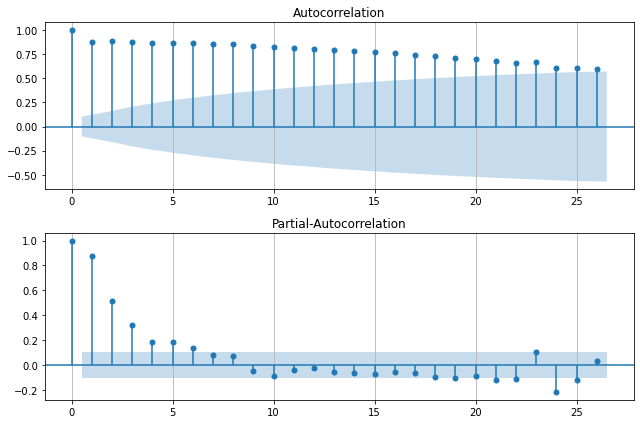

In [56]:
fn.modeling.plot_acf_pacf(train,);

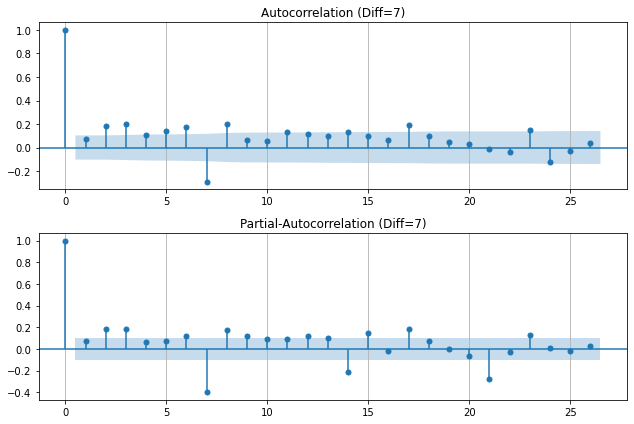

In [57]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [58]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5176.764, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5130.598, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5141.576, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5174.844, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=5176.957, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5129.365, Time=0.80 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=5131.156, Time=2.40 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=5129.076, Time=0.67 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=5129.095, Time=0.44 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=5131.068, Time=1.36 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=5129.106, Time=0.95 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=5148.223, Time=0.62 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  371
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2559.597
Date:                             Mon, 06 Sep 2021   AIC                           5127.193
Time:                                     17:47:40   BIC                           5142.782
Sample:                                          0   HQIC                          5133.389
                                             - 371                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3368      0.027     12.360      0.000       0.283       0.390
ar.S.L7       -0.1742      0.076     -2.283      0.022      -0.324      -0.025
ma.S.L7       -0.3014      0.081     -3.715      0.000      -0.460      -0.142
sigma2      7.478e+04   2114.808     35.358      0.000    7.06e+04    7.89e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.18   Jarque-Bera (JB):              3385.70
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Hospitalized Currently   No. Observations:                  371
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2506.415
Date:                             Mon, 06 Sep 2021   AIC                           5020.830
Time:                                     17:47:40   BIC                           5036.330
Sample:                                 08-01-2020   HQIC                          5026.995
                                      - 08-06-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3478      0.028     12.568      0.000       0.294       0.402
ar.S.L7       -0.1733      0.075     -2.308      0.021      -0.320      -0.026
ma.S.L7       -0.3169      0.080     -3.962      0.000      -0.474      -0.160
sigma2      7.633e+04   2202.097     34.663      0.000     7.2e+04    8.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.54   Jarque-Bera (JB):              3207.72
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

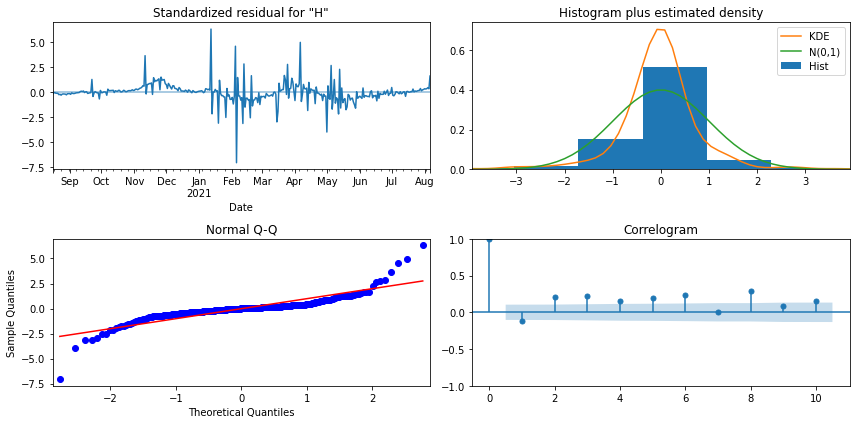

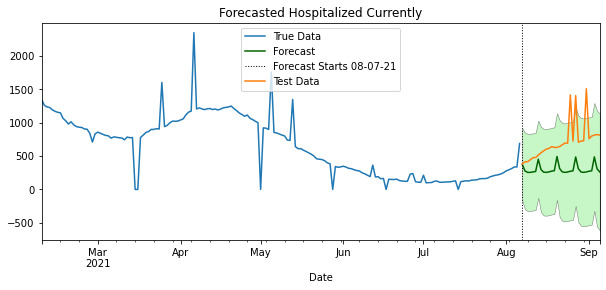

In [59]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Hospitalized Currently   No. Observations:                  401
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2721.174
Date:                             Mon, 06 Sep 2021   AIC                           5450.348
Time:                                     17:47:42   BIC                           5466.171
Sample:                                 08-01-2020   HQIC                          5456.622
                                      - 09-05-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3390      0.028     12.207      0.000       0.285       0.393
ar.S.L7       -0.2159      0.073     -2.977      0.003      -0.358      -0.074
ma.S.L7       -0.2738      0.078     -3.498      0.000      -0.427      -0.120
sigma2      7.775e+04   2228.513     34.890      0.000    7.34e+04    8.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.33   Jarque-Bera (JB):              2804.57
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

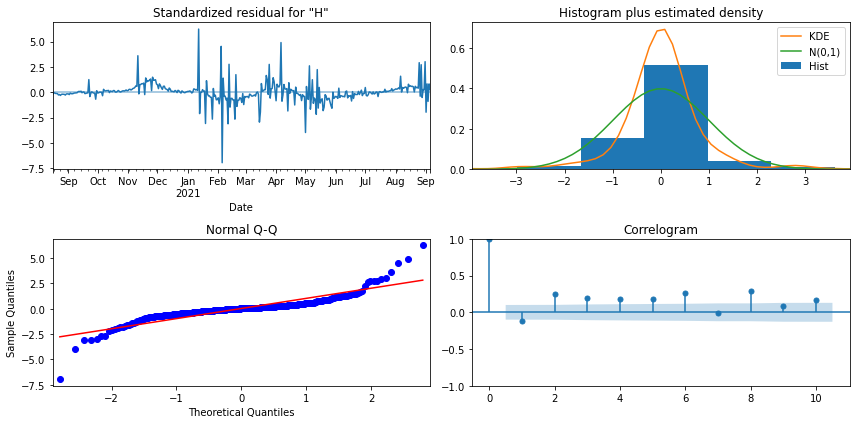

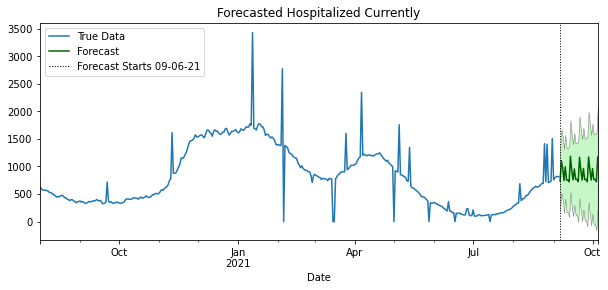

In [60]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

# APPENDIX

### `def` modeling functions

In [ ]:
# def train_test_split_ts(ts,test_size=0.9,split_index=None):
#     """Uses test size by default, split_index overrides it"""
#     if split_index is not None:
#         tts_cutoff = split_index
#     else:
#         tts_cutoff = round(ts.shape[0]*0.9)
#     fmt = "%m-%d-%Y"
#     cutoff_time = ts.index[tts_cutoff]
#     print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
#       ## Use the tts cutoff to do Train test split and plot
#     train = ts.iloc[:tts_cutoff]
#     test = ts.iloc[tts_cutoff:]

#     ## Plot
#     ax = train.plot(label='train')
#     test.plot(label='test')
#     ax.legend()
#     ax.set(ylabel=ts.name)
#     ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
#     ax.legend()
#     ax.set_title(f"Train Test Split for {ts.name}")
#     return train, test


In [ ]:
# ## funtionize diagnosing
# def diagnose_model(model): #keep
#     """Takes a fit statsmodels model and displays the .summary 
#     and plots the built-in plot.diagnostics()"""
#     display(model.summary())
#     model.plot_diagnostics()
#     plt.tight_layout()
    
    
# def get_forecast(model,steps=14): #keep
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = forecast.conf_int()
#     forecast_df['Forecast'] = forecast.predicted_mean
#     forecast_df.columns = ['Lower CI','Upper CI','Forecast']
#     return forecast_df


# def plot_forecast(forecast_df,ts,orig_label='True Data',
#                   forecast_label='Forecast',
#                   forecast_steps=30,
#                   last_n_lags=None,figsize=(10,4)):
#     """Takes a forecast_df from get_df_from_pred and optionally 
#     the training/original time series.
    
#     Plots the original ts, the predicted mean and the 
#     confidence invtervals (using fill between)"""
#     if not isinstance(forecast_df,pd.DataFrame):
#         forecast_df = get_forecast(forecast_df,steps=forecast_steps)
        
#     fig,ax = plt.subplots(figsize=figsize)

#     if last_n_lags is None:
#         last_n_lags = len(ts)
        
#     ts.iloc[-last_n_lags:].plot(label='True Data')

    
#     forecast_df['Forecast'].plot(ax=ax,color='darkgreen',label=forecast_label)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], 
#                     forecast_df['Upper CI'],
#                     color='lightgreen',alpha=0.5,lw=0.5,edgecolor='k')
#     ax.set(title=f'Forecasted {ts.name}')
#     sep = forecast_df.index[0]
#     ax.axvline(sep,label=f"Forecast Starts {sep.strftime('%m-%d-%y')}",lw=1,ls=':',c='k')
#     ax.legend()

#     return fig,ax

    
# def evaluate_model(model,train,test,steps=None,last_n_lags=None):
#     diagnose_model(model)
    
#     if steps is None:
#         steps=len(test)
        
#     forecast_df = get_forecast(model,steps=len(test))
#     fig, ax = plot_forecast(forecast_df,train,last_n_lags=last_n_lags)
    
#     test.plot(ax=ax,label='Test Data')
#     ax.legend()
#     return fig,ax
           
 
